In [1]:
import numpy as np
import matplotlib.pyplot as plt




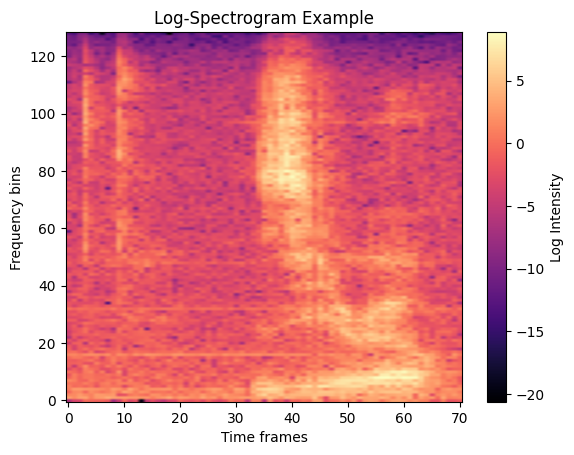

In [3]:
y = np.load('y_digits.npy')
x = np.load('x_digits.npy')

plt.imshow(x[2], aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label="Log Intensity")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.title("Log-Spectrogram Example")
plt.show()

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np


X_tensor = np.expand_dims(x, axis=-1).astype(np.float32)
Y_tensor = y.astype(np.float32)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, Y_tensor, test_size=0.3, stratify=Y_tensor
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp
)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

2025-11-16 11:05:42.787287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(24941, 129, 71, 1) (5345, 129, 71, 1) (5345, 129, 71, 1) (24941,) (5345,) (5345,)


I0000 00:00:1763287549.103351   15760 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13337 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def vgg_block(num_convs, out_channels):
    block = tf.keras.Sequential()
    for _ in range(num_convs):
        block.add(layers.Conv2D(out_channels, kernel_size=3, padding="same", activation="relu"))
    block.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    return block

class Net(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.classes = num_classes

        self.conv_blks = models.Sequential([
            vgg_block(3, 256),
            vgg_block(3, 256),
            vgg_block(3, 256),
        ])

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(4096, activation="relu")
        self.dense2 = layers.Dense(4096, activation="relu")
        self.dropout = layers.Dropout(0.5)
        self.out_layer = layers.Dense(num_classes)

    def call(self, x, training=False):
        x = self.conv_blks(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        if training:
            x = self.dropout(x, training=training)
        logits = self.out_layer(x)
        pred_digits = tf.argmax(logits, axis=1)
        return logits, pred_digits


In [6]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

model = Net()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

num_epochs = 10
fraction = 0.3
patience = 3
threshold = 0.01
best_val_loss = 999999
counter = 0
discardLimit = (1 - fraction) * len(train_dataset)

train_losses = []
val_losses = []

class ManualReduceLROnPlateau:
    def __init__(self, optimizer, factor=0.5, patience=1, min_delta=0.01, min_lr=1e-7, verbose=1):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_delta = min_delta
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = float("inf")

    def step(self, current):
        if self.best - current > self.min_delta:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(self.optimizer.learning_rate.numpy())
                new_lr = max(old_lr * self.factor, self.min_lr)
                self.optimizer.learning_rate.assign(new_lr)
                if self.verbose:
                    print(f"ReduceLROnPlateau reducing learning rate to {new_lr:.6f}")
                self.wait = 0

reduce_lr = ManualReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=1,
    verbose=1,
    min_delta=0.01
)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    total_loss = 0.0
    actual_batches = 0
    discarded_batches = 0

    for images, targets in tqdm(train_dataset):
        random_number = np.random.rand()
        if random_number > fraction and discarded_batches < discardLimit:
            discarded_batches += 1
            continue

        actual_batches += 1
        with tf.GradientTape() as tape:
            logits, _ = model(images, training=True)
            loss = loss_fn(targets, logits)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        total_loss += loss.numpy()
        print(f"Loss = {loss.numpy():.4f}, actual_batches = {actual_batches}, discarded_batches = {discarded_batches}")

    avg_loss = total_loss / max(actual_batches, 1)
    print("Epoch finished, looking at validation set...")

    val_loss = 0.0
    val_batches = 0
    for images, targets in val_dataset:
        logits, _ = model(images, training=False)
        loss = loss_fn(targets, logits)
        val_loss += loss.numpy()
        val_batches += 1

    avg_val_loss = val_loss / max(val_batches, 1)

    reduce_lr.step(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f}, lr = {optimizer.learning_rate}")
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    if best_val_loss - avg_val_loss > threshold:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model.")
        best_val_loss = avg_val_loss
        counter = 0
        model.save_weights("Net_best.weights.h5")
    else:
        print(f"No significant improvement in validation loss. Best: {best_val_loss:.4f}, Current: {avg_val_loss:.4f} for {counter+1} epochs.")
        counter += 1

    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Epoch 1/10


  0%|          | 1/390 [00:03<25:25,  3.92s/it]

Loss = 2.3030, actual_batches = 1, discarded_batches = 0


  1%|▏         | 5/390 [00:05<05:49,  1.10it/s]

Loss = 2.4573, actual_batches = 2, discarded_batches = 3


  3%|▎         | 11/390 [00:06<03:03,  2.06it/s]

Loss = 2.2988, actual_batches = 3, discarded_batches = 8


  4%|▍         | 16/390 [00:08<02:32,  2.45it/s]

Loss = 2.3145, actual_batches = 4, discarded_batches = 12


  5%|▌         | 21/390 [00:10<02:16,  2.71it/s]

Loss = 2.3103, actual_batches = 5, discarded_batches = 16


  6%|▌         | 24/390 [00:11<02:28,  2.47it/s]

Loss = 2.3051, actual_batches = 6, discarded_batches = 18


  6%|▋         | 25/390 [00:13<03:11,  1.91it/s]

Loss = 2.3048, actual_batches = 7, discarded_batches = 18


  7%|▋         | 28/390 [00:14<03:08,  1.92it/s]

Loss = 2.2927, actual_batches = 8, discarded_batches = 20


  7%|▋         | 29/390 [00:16<03:55,  1.53it/s]

Loss = 2.2981, actual_batches = 9, discarded_batches = 20


  8%|▊         | 30/390 [00:17<04:44,  1.27it/s]

Loss = 2.2974, actual_batches = 10, discarded_batches = 20


  8%|▊         | 33/390 [00:19<04:02,  1.47it/s]

Loss = 2.2838, actual_batches = 11, discarded_batches = 22


  9%|▉         | 36/390 [00:20<03:39,  1.62it/s]

Loss = 2.2810, actual_batches = 12, discarded_batches = 24


  9%|▉         | 37/390 [00:22<04:26,  1.33it/s]

Loss = 2.2531, actual_batches = 13, discarded_batches = 24


 10%|█         | 40/390 [00:23<03:51,  1.51it/s]

Loss = 2.3003, actual_batches = 14, discarded_batches = 26


 12%|█▏        | 45/390 [00:25<02:49,  2.03it/s]

Loss = 2.0755, actual_batches = 15, discarded_batches = 30


 12%|█▏        | 46/390 [00:26<03:32,  1.62it/s]

Loss = 2.2528, actual_batches = 16, discarded_batches = 30


 15%|█▍        | 57/390 [00:30<02:29,  2.23it/s]

Loss = 2.1952, actual_batches = 17, discarded_batches = 40


 15%|█▍        | 58/390 [00:32<03:00,  1.84it/s]

Loss = 2.0900, actual_batches = 18, discarded_batches = 40


 15%|█▌        | 60/390 [00:34<03:17,  1.68it/s]

Loss = 2.0284, actual_batches = 19, discarded_batches = 41


 16%|█▌        | 63/390 [00:35<03:11,  1.71it/s]

Loss = 2.0057, actual_batches = 20, discarded_batches = 43


 16%|█▋        | 64/390 [00:37<03:52,  1.40it/s]

Loss = 1.9487, actual_batches = 21, discarded_batches = 43


 17%|█▋        | 66/390 [00:39<03:55,  1.38it/s]

Loss = 1.8630, actual_batches = 22, discarded_batches = 44


 18%|█▊        | 72/390 [00:40<02:33,  2.08it/s]

Loss = 2.0853, actual_batches = 23, discarded_batches = 49


 19%|█▉        | 75/390 [00:42<02:34,  2.04it/s]

Loss = 1.8171, actual_batches = 24, discarded_batches = 51


 20%|█▉        | 77/390 [00:43<02:50,  1.83it/s]

Loss = 2.0848, actual_batches = 25, discarded_batches = 52


 21%|██        | 80/390 [00:45<02:45,  1.87it/s]

Loss = 2.0487, actual_batches = 26, discarded_batches = 54


 22%|██▏       | 87/390 [00:46<01:53,  2.67it/s]

Loss = 1.9329, actual_batches = 27, discarded_batches = 60


 26%|██▌       | 100/390 [00:48<01:06,  4.38it/s]

Loss = 1.9820, actual_batches = 28, discarded_batches = 72


 26%|██▋       | 103/390 [00:49<01:18,  3.66it/s]

Loss = 1.9229, actual_batches = 29, discarded_batches = 74


 27%|██▋       | 107/390 [00:51<01:24,  3.34it/s]

Loss = 1.8511, actual_batches = 30, discarded_batches = 77


 28%|██▊       | 108/390 [00:52<01:51,  2.54it/s]

Loss = 1.7948, actual_batches = 31, discarded_batches = 77


 28%|██▊       | 109/390 [00:54<02:22,  1.97it/s]

Loss = 1.7085, actual_batches = 32, discarded_batches = 77


 29%|██▉       | 113/390 [00:55<02:08,  2.16it/s]

Loss = 1.8988, actual_batches = 33, discarded_batches = 80


 30%|███       | 117/390 [00:57<01:58,  2.30it/s]

Loss = 1.6944, actual_batches = 34, discarded_batches = 83


 32%|███▏      | 125/390 [00:59<01:23,  3.17it/s]

Loss = 1.6962, actual_batches = 35, discarded_batches = 90


 34%|███▍      | 134/390 [01:00<01:04,  3.98it/s]

Loss = 1.5591, actual_batches = 36, discarded_batches = 98


 35%|███▍      | 136/390 [01:02<01:21,  3.14it/s]

Loss = 1.9298, actual_batches = 37, discarded_batches = 99


 37%|███▋      | 146/390 [01:06<01:25,  2.86it/s]

Loss = 1.5595, actual_batches = 38, discarded_batches = 108


 42%|████▏     | 163/390 [01:07<00:49,  4.63it/s]

Loss = 1.3361, actual_batches = 39, discarded_batches = 124


 42%|████▏     | 164/390 [01:09<01:02,  3.59it/s]

Loss = 1.6293, actual_batches = 40, discarded_batches = 124


 42%|████▏     | 165/390 [01:11<01:20,  2.78it/s]

Loss = 1.6693, actual_batches = 41, discarded_batches = 124


 43%|████▎     | 166/390 [01:12<01:41,  2.21it/s]

Loss = 1.5952, actual_batches = 42, discarded_batches = 124


 44%|████▍     | 171/390 [01:14<01:27,  2.49it/s]

Loss = 1.5501, actual_batches = 43, discarded_batches = 128


 44%|████▍     | 173/390 [01:15<01:40,  2.16it/s]

Loss = 1.4586, actual_batches = 44, discarded_batches = 129


 45%|████▍     | 174/390 [01:17<02:04,  1.73it/s]

Loss = 1.5048, actual_batches = 45, discarded_batches = 129


 45%|████▍     | 175/390 [01:18<02:31,  1.42it/s]

Loss = 1.5470, actual_batches = 46, discarded_batches = 129


 46%|████▌     | 179/390 [01:19<01:33,  2.26it/s]


KeyboardInterrupt: 

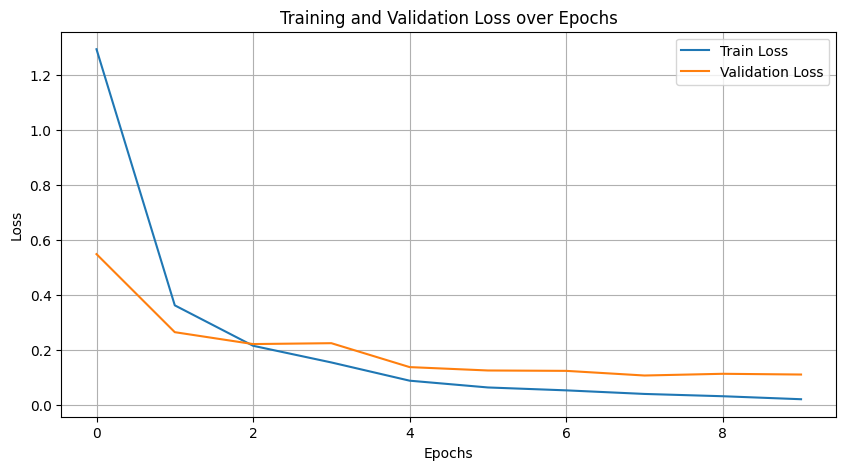

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [25]:

import tensorflow as tf
from tqdm import tqdm

modelEval = Net(num_classes=10)
dummy_input = tf.random.normal((1, 129, 71, 1))
_ = modelEval(dummy_input)
modelEval.load_weights("Net_best.weights.h5")
modelEval.compile()

modelEval.trainable = False

avg_train_performance = 0.0
for images, targets in tqdm(train_dataset):
    targets = tf.cast(targets, tf.int64)
    logits, arg_max_pred = modelEval(images, training=False)
    avg_train_performance += tf.equal(targets, arg_max_pred).numpy().sum().item() / len(targets)

avg_train_performance = avg_train_performance / len(train_dataset)

avg_val_performance = 0.0
for images, targets in tqdm(val_dataset):
    targets = tf.cast(targets, tf.int64)
    logits, arg_max_pred = modelEval(images, training=False)
    avg_val_performance += tf.equal(targets, arg_max_pred).numpy().sum().item() / len(targets)

avg_val_performance = avg_val_performance / len(val_dataset)


test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

avg_test_performance = 0.0
for images, targets in tqdm(test_dataset):
    targets = tf.cast(targets, tf.int64)
    logits, arg_max_pred = modelEval(images, training=False)
    avg_test_performance += tf.equal(targets, arg_max_pred).numpy().sum().item() / len(targets)

avg_test_performance = avg_test_performance / len(test_dataset)

print(f"Train Accuracy: {avg_train_performance:.4f}")
print(f"Validation Accuracy: {avg_val_performance:.4f}")
print(f"Test Accuracy: {avg_test_performance:.4f}")

100%|██████████| 390/390 [03:22<00:00,  1.92it/s]


Train Accuracy: 0.9912


100%|██████████| 84/84 [00:42<00:00,  1.97it/s]

Train Accuracy: 0.9912
Validation Accuracy: 0.9666
Test Accuracy: 0.9652


I0000 00:00:1759062111.986090  160881 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12555 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0
2025-09-28 14:21:52.836714: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 913738476 exceeds 10% of free system memory.
  0%|          | 1/250 [01:02<4:20:16, 62.72s/it]

Iteration 1/50, Loss = 2.3074


  1%|          | 2/250 [01:05<1:52:55, 27.32s/it]

Iteration 2/50, Loss = 2.3069


  1%|          | 3/250 [01:07<1:05:30, 15.91s/it]

Iteration 3/50, Loss = 2.3050


  2%|▏         | 4/250 [01:10<43:23, 10.58s/it]  

Iteration 4/50, Loss = 2.3059


  2%|▏         | 5/250 [01:12<31:22,  7.69s/it]

Iteration 5/50, Loss = 2.2952


  2%|▏         | 6/250 [01:15<24:08,  5.93s/it]

Iteration 6/50, Loss = 2.3018


  3%|▎         | 7/250 [01:17<19:33,  4.83s/it]

Iteration 7/50, Loss = 2.2959


  3%|▎         | 8/250 [01:22<19:08,  4.75s/it]

Iteration 8/50, Loss = 2.2955


  4%|▎         | 9/250 [01:24<16:22,  4.08s/it]

Iteration 9/50, Loss = 2.2734


  4%|▍         | 10/250 [01:27<14:28,  3.62s/it]

Iteration 10/50, Loss = 2.2834


  4%|▍         | 11/250 [01:29<13:02,  3.27s/it]

Iteration 11/50, Loss = 2.2538


  5%|▍         | 12/250 [01:32<12:02,  3.04s/it]

Iteration 12/50, Loss = 2.2430


  5%|▌         | 13/250 [01:34<11:20,  2.87s/it]

Iteration 13/50, Loss = 2.2386


  6%|▌         | 14/250 [01:37<10:41,  2.72s/it]

Iteration 14/50, Loss = 2.2813


  6%|▌         | 15/250 [01:39<10:12,  2.60s/it]

Iteration 15/50, Loss = 2.2348


  6%|▋         | 16/250 [01:41<09:51,  2.53s/it]

Iteration 16/50, Loss = 2.1380


  7%|▋         | 17/250 [01:44<09:46,  2.52s/it]

Iteration 17/50, Loss = 2.1856


  7%|▋         | 18/250 [01:46<09:40,  2.50s/it]

Iteration 18/50, Loss = 2.1336


  8%|▊         | 19/250 [01:49<09:35,  2.49s/it]

Iteration 19/50, Loss = 1.8701


  8%|▊         | 20/250 [01:51<09:29,  2.48s/it]

Iteration 20/50, Loss = 2.0863


  8%|▊         | 21/250 [01:55<10:44,  2.82s/it]

Iteration 21/50, Loss = 1.9234


  9%|▉         | 22/250 [01:57<10:13,  2.69s/it]

Iteration 22/50, Loss = 2.0199


  9%|▉         | 23/250 [02:00<10:01,  2.65s/it]

Iteration 23/50, Loss = 1.8958


 10%|▉         | 24/250 [02:02<09:38,  2.56s/it]

Iteration 24/50, Loss = 2.0164


 10%|█         | 25/250 [02:05<09:21,  2.50s/it]

Iteration 25/50, Loss = 1.9071


 10%|█         | 26/250 [02:07<09:09,  2.45s/it]

Iteration 26/50, Loss = 2.0664


 11%|█         | 27/250 [02:09<09:07,  2.45s/it]

Iteration 27/50, Loss = 1.8473


 11%|█         | 28/250 [02:12<09:02,  2.44s/it]

Iteration 28/50, Loss = 1.7101


 12%|█▏        | 29/250 [02:14<08:57,  2.43s/it]

Iteration 29/50, Loss = 1.8932


 12%|█▏        | 30/250 [02:17<08:56,  2.44s/it]

Iteration 30/50, Loss = 2.0676


 12%|█▏        | 31/250 [02:19<08:54,  2.44s/it]

Iteration 31/50, Loss = 1.8030


 13%|█▎        | 32/250 [02:22<08:52,  2.44s/it]

Iteration 32/50, Loss = 1.8553


 13%|█▎        | 33/250 [02:24<08:52,  2.46s/it]

Iteration 33/50, Loss = 1.7041


 14%|█▎        | 34/250 [02:26<08:48,  2.45s/it]

Iteration 34/50, Loss = 1.8708


 14%|█▍        | 35/250 [02:31<10:43,  2.99s/it]

Iteration 35/50, Loss = 1.7579


 14%|█▍        | 36/250 [02:33<10:12,  2.86s/it]

Iteration 36/50, Loss = 1.8290


 15%|█▍        | 37/250 [02:36<09:39,  2.72s/it]

Iteration 37/50, Loss = 1.6781


 15%|█▌        | 38/250 [02:38<09:12,  2.61s/it]

Iteration 38/50, Loss = 1.4257


 16%|█▌        | 39/250 [02:40<08:52,  2.53s/it]

Iteration 39/50, Loss = 1.3428


 16%|█▌        | 40/250 [02:43<08:39,  2.47s/it]

Iteration 40/50, Loss = 1.5799


 16%|█▋        | 41/250 [02:45<08:28,  2.43s/it]

Iteration 41/50, Loss = 1.4958


 17%|█▋        | 42/250 [02:47<08:19,  2.40s/it]

Iteration 42/50, Loss = 1.6466


 17%|█▋        | 43/250 [02:50<08:12,  2.38s/it]

Iteration 43/50, Loss = 1.8625


 18%|█▊        | 44/250 [02:52<08:12,  2.39s/it]

Iteration 44/50, Loss = 2.2699


 18%|█▊        | 45/250 [02:55<08:10,  2.39s/it]

Iteration 45/50, Loss = 2.4712


 18%|█▊        | 46/250 [02:57<08:15,  2.43s/it]

Iteration 46/50, Loss = 2.3673


 19%|█▉        | 47/250 [02:59<08:14,  2.44s/it]

Iteration 47/50, Loss = 2.2346


 19%|█▉        | 48/250 [03:05<11:15,  3.35s/it]

Iteration 48/50, Loss = 4.2648


 20%|█▉        | 49/250 [03:07<10:23,  3.10s/it]

Iteration 49/50, Loss = 2.4615


 20%|██        | 50/250 [03:10<12:41,  3.81s/it]

Iteration 50/50, Loss = 2.3035


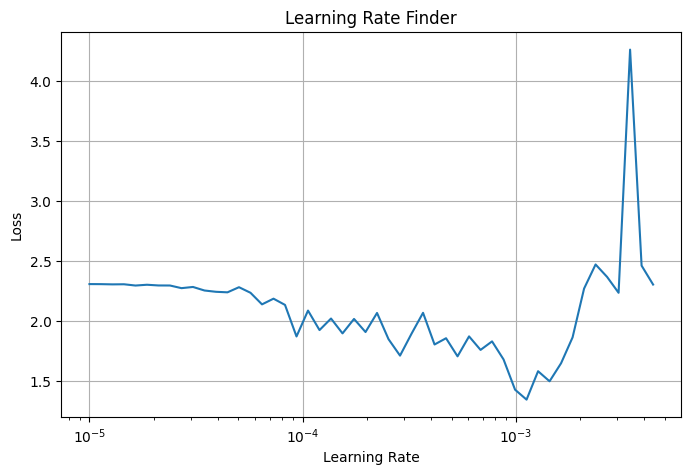

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
batch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(1000).batch(batch_size)


model = Net(num_classes=10)
dummy_input = tf.zeros((1, 129, 71, 1))
_ = model(dummy_input)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)

lrs = []
losses = []

lr_start = 1e-5
lr_end = 0.5e-2
num_iters = 50
mult = (lr_end / lr_start) ** (1/num_iters)
lr = lr_start

iter_count = 0
for X_batch, y_batch in tqdm(train_dataset):
    if iter_count >= num_iters:
        break

    with tf.GradientTape() as tape:
        logits, preds = model(X_batch, training=True)
        loss = loss_fn(y_batch, logits)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print(f"Iteration {iter_count+1}/{num_iters}, Loss = {loss.numpy():.4f}")

    lrs.append(lr)
    losses.append(loss.numpy())

    lr *= mult
    optimizer.learning_rate = lr

    iter_count += 1

plt.figure(figsize=(8, 5))
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.grid(True)
plt.show()